# imports

In [1]:
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.pyplot.ion()
%matplotlib inline
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, graph_summary

from qlp.tdse import TDSE, embed_qubo_example, convert_params

from qlpdb.tdse.models import Tdse

# Setup

## Graph specific parameters 

Creates a line graph `o-o-o-...-o`

In [2]:
nvertices = 2
graph, tag = gt.generate_nn_graph(nvertices)
directed = False

## ILP / QUBO setup

Initializes the Qubo for the Minimum Dominating Set problem

In [3]:
penalty = 2
qubo = get_mds_qubo(
    graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
)
qubo_constant = penalty * nvertices

## Set up ising model

Computes the corresponding Ising model parameters for the QUBO

**if embed is True:** 
    This embeds the QUBO into a chimera graph. Currently there is only an explicit result from G(2). I will in the future actually embed with DWave minorminer.

In [4]:
Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())

embed = True  # nvertices = [2, 3] available
if embed:
    qubo, embedding = embed_qubo_example(nvertices)
    hi_for_offset = np.array(
        [
            hi[key]
            for key in np.sort(list(embedding.keys()))
            for count in range(len(embedding[key]))
        ]
    )
    Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
else:
    
    hi_for_offset = hi

graph_params = graph_summary(tag, graph, qubo)
print(graph_params)

{'tag': 'NN(2)', 'total_vertices': 2, 'total_edges': 1, 'total_qubits': 5, 'max_edges': 1, 'adjacency': [[0, 1]], 'adjacency_hash': '2864ee150babb3f03de5e76a1733df4b'}


## Anneal specific parameters

Parameters which are related to converting physical unites to unitless units

* **annealing_time:** Annealing time as defined from s = [0, 1] in microseconds
* **normalized_time:** This is s. Set it to < 0 or > 1 if offset is used to allow for a complete annealing schedule. The total time in microseconds will increase accordingly.
* **energyscale:** Converts units from D-Wave parameters to unitless parameters (see eq. 65 in the notes)

In [5]:
annealing_time = 0.0003
normalized_time = [-0.2, 1.2]  # make larger range for complete offsets

# assume annealing_time unit in microsecond and energy unit in Ghz
def energyscaleconversion(annealing_time):
    return annealing_time * 1000.0 * (2.0 * np.pi)

energyscale = energyscaleconversion(annealing_time)
ising_params = {"Jij": Jij, "hi": hi, "c": c, "energyscale": energyscale, "qubo_constant": qubo_constant, "penalty": penalty}
print(ising_params)

{'Jij': array([[ 0.,  0.,  0.,  2., -4.],
       [ 0.,  0.,  0., -1., -1.],
       [ 0.,  0.,  0., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]]), 'hi': array([-0.75,  1.  ,  1.  , -1.5 , -0.75]), 'c': 5.0, 'energyscale': 1.8849555921538759, 'qubo_constant': 4, 'penalty': 2}


## Anneal curve specific parameters

Parameters which specify how the anneal curve is realized:

* **offset:** This is a string argument to the fcn method of the class AnnealOffset in qlp.mds.mds_qlpdb. Define your own anneal offset routine here or call
an existing one. E-mail me if you need more explanation.
* **offset_min, offset_range:** Argument to AnnealOffset class. Specify offset boundaries and are set later in a loop.
* **anneal_curve:** The realized curve. Currently implemented are linear, logistic and d-wave.
* **fill_value:** If normalized_time is extended beyond (0, 1), this option decides whether to extrapolate the anneal schedule, or truncate it at the nearest value.

In [6]:
offset = "negbinary"
anneal_curve = "linear"
fill_value = "truncate"

## Parameters for numerical solve of ODE

Parameters to solve the ODE. See also `scipy.integrate.solve_ivp`.

In [7]:
solver_params = dict()
solver_params["method"] = "RK45"
solver_params["rtol"] = 1e-6
solver_params["atol"] = 1e-7

## System parameters

Parameters used to specify the initial conditions of the system:

* **pure_tdse:** This is a boolean (True / False) flag and runs the pure state solver.
* **mixed_tdse:** This boolean flag runs the mixed state solver.
* **temp:** This sets the temperature for the mixed state solver in kelvins.
* **initial_wavefunction:** For the pure state solver, the initial wavefunc- tion can be chosen to be the ground state of ∑σx (transverse) or H(0)(real). For the DWave anneal schedule, or when annealing offsets are used without extended annealing times, these two options are not the same. Can be "true" or "transverse".


In [8]:
pure_tdse = True
mixed_tdse = False
temp = 15E-3
initial_wavefunction = "true"

## Output parameters

Parameters used for visializing results:
* **degeneracy_tol:** This sets the numerical tolerance as to when an excited- state is labeled as degenerate to the ground state. This is important for graphs with degenerate ground states.
* **debug:** Write more output during computations.
* **save_result:** Store results to pickle files. 

In [9]:
degeneracy_tol = 2e-2
debug = False
save_result = True

# Run computations

In this section we run over different anneal time offsets

offset 0.0


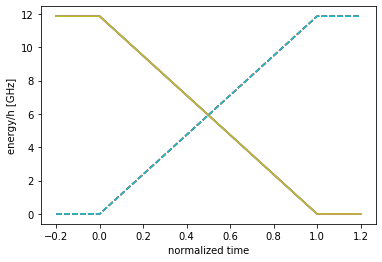

entropy param 2 abcdfabceg
pure measurement not in db
test rho
(32, 32)
eig rho [-2.42607118e-16 -1.50090475e-16 -2.89290009e-17 -1.29132152e-17
 -8.30350908e-18 -3.72749331e-18 -2.58194591e-18 -8.71548600e-19
 -7.28110562e-19 -1.14261497e-19 -4.54631176e-33 -2.80353429e-33
 -1.35667622e-33 -1.05812963e-33 -4.16081684e-34 -2.63101981e-34
 -5.94111078e-35 -2.53819933e-35  9.09721494e-35  3.34499052e-34
  8.68220683e-34  4.29771945e-33  8.02154437e-19  1.43686037e-18
  1.86684831e-18  2.03193964e-18  5.01952438e-18  5.80193014e-18
  1.06642681e-17  1.51833926e-17  3.66352519e-16  1.00000000e+00]
rhoA
<class 'numpy.ndarray'>
(2, 2, 2, 2)
eig rhoA [1.00000008e-10 1.00000064e-10 1.00000119e-10 1.00000000e+00]
test rho
(32, 32)
eig rho [-2.53969610e-16 -1.48527903e-16 -1.61778211e-17 -1.21698785e-17
 -7.96869714e-18 -7.66139642e-18 -7.34073511e-18 -2.32381033e-18
 -1.53531727e-18 -8.57894118e-19 -5.00006468e-19 -8.64282263e-20
 -5.03297377e-23 -3.52969600e-33 -1.52120141e-33 -6.47436272e-34


(32, 32)
eig rho [-2.23803146e-16 -3.89145025e-17 -2.09290436e-17 -1.70860035e-17
 -1.51014521e-17 -9.47634869e-18 -6.85358596e-18 -4.96597918e-18
 -4.56919991e-18 -3.98799056e-18 -2.91699717e-18 -2.55554987e-18
 -1.44982381e-18 -6.37115528e-19 -2.32047596e-19  3.43679914e-20
  1.30677715e-19  7.33209832e-19  1.22025793e-18  1.96957156e-18
  2.42547863e-18  4.22855788e-18  4.64153799e-18  5.84614580e-18
  6.93598287e-18  7.22059281e-18  1.31662406e-17  2.22694373e-17
  3.19385211e-17  4.18580544e-17  4.78366468e-17  9.99966948e-01]
rhoA
<class 'numpy.ndarray'>
(2, 2, 2, 2)
eig rhoA [-0.21839537 -0.03839402 -0.01354178  0.91898814]
test rho
(32, 32)
eig rho [-2.71680149e-16 -3.66885846e-17 -2.51760900e-17 -1.73236860e-17
 -1.31079699e-17 -1.21770574e-17 -8.64208063e-18 -6.87786682e-18
 -5.76581972e-18 -4.30056771e-18 -2.36906432e-18 -1.83306297e-18
 -1.37546618e-18 -9.04494552e-19 -4.13638451e-19 -3.02070536e-19
 -1.90178301e-19  2.87082860e-19  5.48694285e-19  9.93854451e-19
  2.062907

test rho
(32, 32)
eig rho [-2.41453425e-16 -1.07873265e-16 -1.93562861e-18 -6.08379543e-19
 -3.06225440e-19 -2.03755307e-19 -1.18146985e-19 -6.26353731e-20
 -5.79022224e-20 -1.10457010e-20 -6.43812423e-21 -3.94855831e-21
 -2.60762942e-21 -1.36497202e-21 -7.00348242e-22 -2.43549828e-22
 -1.13867319e-23  1.92620853e-23  5.67540775e-23  3.98509474e-22
  7.77132718e-22  1.49634063e-21  3.21492707e-21  7.54297988e-21
  1.37431388e-20  9.11072758e-20  1.28273607e-19  4.32759321e-19
  7.29737667e-19  4.29038802e-18  8.71594423e-17  9.99902179e-01]
rhoA
<class 'numpy.ndarray'>
(2, 2, 2, 2)
eig rhoA [-0.71984424 -0.0202421   0.01866384  0.74246409]
test rho
(32, 32)
eig rho [-3.96593074e-16 -2.02215160e-16 -1.73993111e-18 -6.78909870e-19
 -2.72866181e-19 -1.34046807e-19 -6.77548817e-20 -2.06521821e-20
 -2.00452414e-20 -2.99900230e-21 -1.44403072e-21 -7.43045388e-22
 -4.61264576e-22 -2.37815471e-22 -4.42471467e-23 -3.04031022e-24
  1.77611698e-24  1.53956638e-23  6.43744464e-23  1.39251026e-22
 

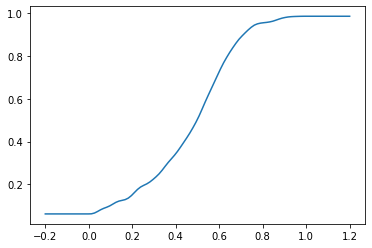

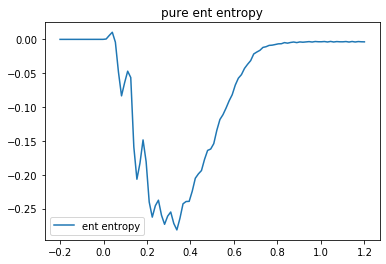

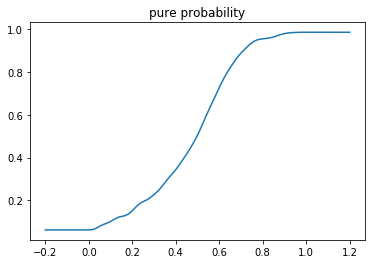

In [10]:
#%%timeit -n 1 -r 1

# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = [0.0]

for offset_min in offset_min_list:
    print("offset", offset_min)
    offset_min = offset_min
    offset_range = -2 * offset_min

    offset_params = {
        "annealing_time": annealing_time,
        "normalized_time": normalized_time,
        "offset": offset,
        "hi_for_offset": hi_for_offset,
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
        "anneal_curve": anneal_curve,
    }

    # instantiate ode solver
    tdse = TDSE(graph_params, ising_params, offset_params, solver_params)

    # plot anneal schedule
    tdse.AS.plot(normalized_time)

    # get offset list to get partition for entanglement entropy
    nA, indicesA = tdse.find_partition()
    print("entropy param",nA,indicesA)
    reg = 1e-10
    entropy_params = {"nA": nA, "indicesA": indicesA, "reg": reg}
    
    ############################################################
    ###### code block for thermal mixed state simultation ######
    ############################################################
    if mixed_tdse:
        wave_params = dict()
        wave_params["type"] = "mixed"
        wave_params["temp"] = temp
        wave_params["initial_wavefunction"] = initial_wavefunction
        #query = Tdse.objects.filter(
        #    graph__tag=graph_params["tag"],
        #    offset__contains=convert_params(offset_params),
        #    ising__contains=convert_params(ising_params),
        #    solver__contains=solver_params,
        #    wave__contains=wave_params,
        #).first()
        query=False
        if not query:
            print("mixed measurement not in db")
            # initial density matrix
            rho = tdse.init_densitymatrix(temp, initial_wavefunction, debug=debug)
            # solve
            sol_densitymatrix = tdse.solve_mixed(rho)
            
            # overlap with Ising ground state
            gs_idx, Isingenergy, Isingeigv = tdse.ground_state_degeneracy(
                tdse.IsingH, degeneracy_tol, debug=debug
            )
            project = sum(
                [
                    np.kron(Isingeigv[:, idx], np.conj(Isingeigv[:, idx]))
                    for idx in gs_idx
                ]
            )
            prob = np.asarray(
                [
                    np.absolute((np.dot(np.conj(project), sol_densitymatrix.y[:, i])))
                    for i in range(sol_densitymatrix.t.size)
                ]
            )
            
            # save result to EspressoDB
            #query = tdse.summary(
            #    wave_params=wave_params,
            #    instance=tdse,
            #    solution=sol_densitymatrix,
            #    time=sol_densitymatrix.t,
            #    probability=prob,
            #    save = save_result,
            #)
        # calculate entanglement entropy
        # this example partion 4 qubits into A:(3,4) and B:(1,2)
        entropy = np.asarray(
            [
                tdse.ent_entropy(sol_densitymatrix.y[:, i], **entropy_params)
                for i in range(sol_densitymatrix.t.size)
            ]
        ).real
        # plot entropy
        plt.figure("mixed entropy")
        #plt.plot(query.time, entropy)
        plt.plot(sol_densitymatrix.t, entropy)
        plt.legend(["ent entropy"])
        plt.title("mixed ent entropy")

        # plot overlap with Ising g.s.
        plt.figure("mixed prob")
        #plt.plot(query.time, query.prob)
        plt.plot(sol_densitymatrix.t, prob)
        plt.title("mixed probability")
        #print(f"Final Prob: {query.prob[-1]}")

    ############################################################
    ###### end of code block for thermal mixed state simultation ######
    ############################################################

    if pure_tdse:
        wave_params = dict()
        wave_params["type"] = "pure"
        wave_params["temp"] = 0
        wave_params["initial_wavefunction"] = initial_wavefunction
        #query = Tdse.objects.filter(
        #    graph__tag=graph_params["tag"],
        #    offset__contains=convert_params(offset_params),
        #    ising__contains=convert_params(ising_params),
        #    solver__contains=solver_params,
        #    wave__contains=wave_params,
        #).first()
        
        query=False
        if not query:
            print("pure measurement not in db")
            # Initial wavefunction
            y1 = tdse.init_wavefunction(initial_wavefunction)
    
            # solve
            sol = tdse.solve_pure(y1, ngrid=2, debug=debug)
    
            # get ground state degeneracy
            ground_state_idx, energy, eigv = tdse.ground_state_degeneracy(
                tdse.IsingH, degeneracy_tol, debug=debug
            )
    
            # calculate probability overlap with Ising ground state
            prob = [tdse.calculate_overlap(eigv, sol.y[:, i], ground_state_idx) for i in range(sol.t.size)]
            plt.plot(sol.t, prob) # plot prob
    
            #query = tdse.summary(
            #    wave_params=wave_params,
            #    instance=tdse,
            #    solution=sol,
            #    time=sol.t,
            #    probability=prob,
            #    save = save_result,
            #)
        # calculate entropy
        entropy = np.asarray(
                [
                    tdse.ent_entropy(np.kron(sol.y[:, i], np.conj(sol.y[:, i])), nA, indicesA, reg)
                    for i in range(sol.t.size)
                ]
            ).real
        # plot entropy
        plt.figure("pure entropy")
        #plt.plot(query.time, entropy)
        plt.plot(sol.t,entropy)
        plt.legend(["ent entropy"])
        plt.title("pure ent entropy")
        # plot overlap with Ising g.s.
        plt.figure("pure probability")
        #plt.plot(query.time, query.prob)
        plt.plot(sol.t, prob)
        plt.title("pure probability")


In [ ]:
from numpy.linalg import eigh

# plot spectrum
with open(query.instance.path, "rb") as file:
    tdse = pickle.load(file)
normalized_time = tdse.offset["normalized_time"]

num_es = 10
# unit conversion
# sol.y = [GHz / h]
make_dimensionless = 1 / energyscale * 1 / tdse.AS.B(normalized_time[1])[0]

fig = plt.figure()
ax = plt.axes()
num_es = 10
gap = dict()

x = []
y = {es: [] for es in range(num_es)}
for s in np.linspace(normalized_time[0], normalized_time[1]):
    eigval, eigvec = eigh(tdse.annealingH(s))
    seigval = (
        np.sort(eigval) * make_dimensionless + tdse.ising["c"] + tdse.ising["qubo_constant"]
    )
    x.append(s)
    for es in y.keys():
        y[es].append(seigval[es])
for es in y.keys():
    ax.errorbar(x=x, y=y[es])
gap = {es: np.array(y[es]) - np.array(y[0]) for es in y.keys()}
plt.draw()
plt.show()
print("ground state energy:", y[0][-1])
print("1st ex state energy:", y[1][-1])
eigval, eigvec = eigh(tdse.annealingH(s))
print("ground state eigvec:", np.round(eigvec[0]))
print("1st ex state eigvec:", np.round(eigvec[1]))

# IGNORE BELOW...

In [ ]:
graph_params

In [ ]:
offset_tag = f"FixEmbedding_AdvanceConstraint_{offset_min}_{offset_range}"
adv = offset_min + offset_range
offset_fcn = [adv for q in range(graph_params["total_vertices"])]
nconstraint = graph_params["total_qubits"] - graph_params["total_vertices"]
offset_constraint = [offset_min for q in range(nconstraint)]
offset_fcn.extend(offset_constraint)
            

In [ ]:
offset_fcn

In [ ]:
a = np.zeros((2**6, 2**6))

In [ ]:
def _set_up_pauli():
    """Creates Pauli matrices and identity
    """
    sigx = np.zeros((2, 2))
    sigz = np.zeros((2, 2))
    id2 = np.identity(2)
    proj0 = np.zeros((2, 2))
    proj1 = np.zeros((2, 2))
    sigx[0, 1] = 1.0
    sigx[1, 0] = 1.0
    sigz[0, 0] = 1.0
    sigz[1, 1] = -1.0
    proj0[0, 0] = 1.0
    proj1[1, 1] = 1.0
    return id2, sigx, sigz, proj0, proj1
ID2, SIG_X, SIG_Z, PROJ_0, PROJ_1 = _set_up_pauli()


In [ ]:
tdse = TDSE(graph_params, ising_params, offset_params, solver_params)

In [ ]:
tdse.graph["total_qubits"] = 6

In [ ]:
V = [-1.4, 0, -1.6, 0, -1.5, -1.5]


In [ ]:
a = sum([tdse.pushtoFock(i, -.5*V[i]*(1-SIG_Z)) for i in range(6)])

In [ ]:
eigval, eigvec = eigh(a)

In [ ]:
eigval

In [ ]:
eigvec[1]